In [1]:
from fastapi import FastAPI, Query
from typing import List
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
# from tensorflow.python.keras import Sequential
import matplotlib.pyplot as plt
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras.layers.recurrent import LSTM
from fastapi.middleware.cors import CORSMiddleware
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover
from pymoo.operators.mutation.pm import PolynomialMutation
from sklearn.model_selection import train_test_split
from datetime import date
from fastapi import FastAPI, Query, HTTPException
from pydantic import BaseModel
from sklearn.preprocessing import MinMaxScaler
from fastapi.responses import JSONResponse
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.util.ref_dirs import get_reference_directions
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate
from bs4 import BeautifulSoup
import requests
from transformers import pipeline

d:\PROJECTS\ANN-GA-Portfolio-Optimization\code\backend\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def fetch_historical_data(tickers):
    data = {}
    # logger.info("List of tickers to fetch historical data")
    # logger.debug(tickers)
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            history = stock.history(period="5y")
            if history.empty:
                print(f"Warning: No data found for {ticker}")
                continue
            data[ticker] = history
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
    return data

In [6]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

def calculate_time_series_statistics(data):
    """
    Calculates statistical metrics (Mean, Std. Dev, Skewness, Kurtosis, Min, Max)
    for each stock's closing price time series.

    Parameters:
    - data (dict): Dictionary with stock tickers as keys and price dicts as values.

    Returns:
    - pd.DataFrame: Table with statistics per stock.
    """
    stats = {
        "Stock": [],
        "Count": [],
        "Mean": [],
        "St.Dev": [],
        "Skewness": [],
        "Kurtosis": [],
        "Min": [],
        "Max": []
    }

    for ticker, price_dict in data.items():
        closes = np.array(price_dict["Close"])
        stats["Stock"].append(ticker)
        stats["Count"].append(len(closes))
        stats["Mean"].append(np.mean(closes))
        stats["St.Dev"].append(np.std(closes))
        stats["Skewness"].append(skew(closes))
        stats["Kurtosis"].append(kurtosis(closes))
        stats["Min"].append(np.min(closes))
        stats["Max"].append(np.max(closes))

    return pd.DataFrame(stats)


In [5]:
def train_ann(data):
    models = {}
    for ticker, prices in data.items():
        X, y = [], []
        for i in range(len(prices["Close"]) - 10):
            X.append(prices["Close"][i:i+10])
            y.append(prices["Close"][i+10])
        X, y = np.array(X), np.array(y)
        
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(32, activation='relu', input_shape=(10,)),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        model.fit(X, y, epochs=50, verbose=0)
        models[ticker] = model
    return models
def predict_future_prices(models, data, duration="1y"):
    future_prices = {}
    duration_map = {"6m": 180, "1y": 365, "5y": 1825, "10y": 3650}
    prediction_days = duration_map.get(duration, 365)

    for ticker, model in models.items():
        last_10_days = np.array(data[ticker]["Close"][-10:]).reshape(1, -1)
        future_preds = []

        for _ in range(prediction_days):
            predicted_price = model.predict(last_10_days)[0][0]
            future_preds.append(predicted_price)
            last_10_days = np.roll(last_10_days, -1)
            last_10_days[0, -1] = predicted_price

        future_prices[ticker] = future_preds

    return future_prices

In [11]:
tickers = ["AAPL", "MSFT", "TSLA", "T"]

In [12]:
import matplotlib.pyplot as plt

def plot_statistics_table(df, title="Time Series Statistics"):
    fig, ax = plt.subplots(figsize=(12, len(df)*0.6 + 1))
    ax.axis("off")

    table = ax.table(cellText=df.round(2).values,
                     colLabels=df.columns,
                     cellLoc='center',
                     loc='center',
                     colColours=['#d2d2d2'] * len(df.columns))

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.1, 1.3)

    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()


C:\Temp\ipykernel_20696\1183877797.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(prices["Close"][i+10])


1/1 [==============================] - 0s 35ms/step


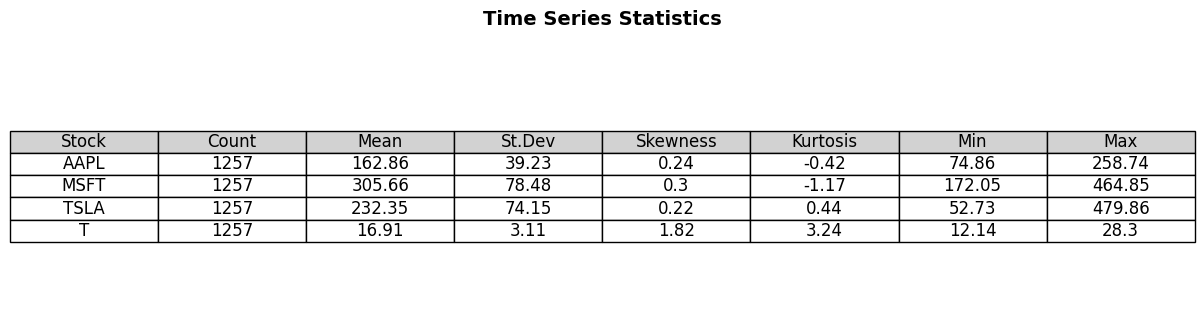

In [13]:
data = fetch_historical_data(tickers)
models = train_ann(data)
future_prices = predict_future_prices(models, data)
statistics_df = calculate_time_series_statistics(data)
plot_statistics_table(statistics_df)


In [ ]:
data = fetch_historical_data(tickers)
# data
prices_df = pd.DataFrame({ticker: pd.Series(prices["Close"]) for ticker, prices in data.items()})
prices_df

,AAPL,MSFT,GOOGL
Date,,,
2020-05-11 00:00:00-04:00,76.653252,178.743576,69.845566
2020-05-12 00:00:00-04:00,75.777245,174.694672,68.431831
2020-05-13 00:00:00-04:00,74.862312,172.052887,67.095711
2020-05-14 00:00:00-04:00,75.322220,172.799515,67.520187
2020-05-15 00:00:00-04:00,74.876915,175.316879,68.326332
...,...,...,...
2025-05-05 00:00:00-04:00,198.889999,436.170013,164.210007
2025-05-06 00:00:00-04:00,198.509995,433.309998,163.229996
2025-05-07 00:00:00-04:00,196.250000,433.350006,151.380005


## Yahoo query - research reports

In [2]:
from yahooquery import Research
r = Research(username='xoyoni7114@nokdot.com', password="weatYAHOOtool")
r.reports(
    report_type='Analyst Report, Insider Activity',
    report_date='Last Week'
)

{0: 'User is unable to access this feature - https://bit.ly/yahoo-finance-api-feedback'}

## Sentiment Analysis

In [14]:
def fetch_historical_data(tickers):
    data = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        history = stock.history(period="5y")
        data[ticker] = history['Close'].values
    return data

def train_ann(data):
    models = {}
    for ticker, prices in data.items():
        X, y = [], []
        for i in range(len(prices) - 10):
            X.append(prices[i:i+10])
            y.append(prices[i+10])
        X, y = np.array(X), np.array(y)
        
        model = Sequential([
            Dense(32, activation='relu', input_shape=(10,)),
            Dense(16, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        model.fit(X, y, epochs=50, verbose=0)
        models[ticker] = model
    return models

def predict_future_prices(models, data, duration="1y"):
    future_prices = {}
    duration_map = {"6m": 180, "1y": 365, "5y": 1825, "10y": 3650}
    prediction_days = duration_map.get(duration, 365)

    for ticker, model in models.items():
        last_10_days = np.array(data[ticker][-10:]).reshape(1, -1)
        future_preds = []

        for _ in range(prediction_days):
            predicted_price = model.predict(last_10_days)[0][0]
            future_preds.append(predicted_price)
            last_10_days = np.roll(last_10_days, -1)
            last_10_days[0, -1] = predicted_price

        future_prices[ticker] = future_preds

    return future_prices

class PortfolioOptimization(Problem):
    def __init__(self, future_prices):
        super().__init__(n_var=len(future_prices), n_obj=2, xl=0, xu=1)
        self.tickers = list(future_prices.keys())
        self.returns = np.array([np.mean(future_prices[t]) for t in self.tickers])
        self.risks = np.array([np.std(future_prices[t]) for t in self.tickers])

        scaler = MinMaxScaler()
        self.returns = scaler.fit_transform(self.returns.reshape(-1, 1)).flatten()
        self.risks = scaler.fit_transform(self.risks.reshape(-1, 1)).flatten()

    def _evaluate(self, X, out, *args, **kwargs):
        returns = np.sum(X * self.returns, axis=1)
        risks = np.sum(X * self.risks, axis=1)
        out["F"] = np.column_stack([-returns, risks])

In [15]:
# Load sentiment analysis model
sentiment_analyzer = pipeline("sentiment-analysis")

# Fetch and analyze sentiment from research reports
def analyze_news_sentiment(reports):
    views = []
    for report in reports:
        sentiment_result = sentiment_analyzer(report["reportTitle"][:512])[0]  # Limit title to 512 chars
        sentiment_score = 1 if sentiment_result['label'] == 'POSITIVE' else -1 if sentiment_result['label'] == 'NEGATIVE' else 0
        views.append({
            "title": report["reportTitle"],
            "sentiment": sentiment_result["label"],
            "score": sentiment_score
        })
    return views
def black_litterman_model(Sigma, Pi, P, Q, tau, Omega):
    # Calculate posterior expected return (μ̂)
    M_inverse = np.linalg.inv(np.dot(np.dot(P.T, np.linalg.inv(Omega)), P) + np.linalg.inv(tau * Sigma))
    mu_tilde = M_inverse @ (np.dot(np.linalg.inv(tau * Sigma), Pi) + np.dot(np.dot(P.T, np.linalg.inv(Omega)), Q))

    # Calculate posterior covariance matrix
    Sigma_tilde = Sigma + M_inverse
    
    return mu_tilde, Sigma_tilde

def optimize_portfolio(future_prices, algorithm_type, views=None):
    problem = PortfolioOptimization(future_prices)
    ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=12)
    
    # Select optimization algorithm
    algorithm = {
        "nsga2": NSGA2(),
        "moead": MOEAD(ref_dirs),
        "nsga3": NSGA3(ref_dirs)
    }.get(algorithm_type)
    
    if not algorithm:
        raise ValueError("Invalid algorithm type")
    
    # Run original optimization
    res = minimize(problem, algorithm, termination=('n_gen', 100), verbose=False)
    best_solution = res.X[np.argmin(res.F[:, 1])]
    total = np.sum(best_solution)
    normalized_allocation = {stock: weight / total for stock, weight in zip(future_prices.keys(), best_solution)}
    
    # Run Black-Litterman if views are provided
    if views:
        sentiment_scores = np.array([v["score"] for v in views])
        Sigma = np.cov(np.array(list(future_prices.values())))
        Pi = np.mean(np.array(list(future_prices.values())), axis=1)
        P = np.eye(len(future_prices))  # Identity matrix for simplicity
        Q = 0.01 * sentiment_scores  # Expected excess return for sentiment
        tau = 0.05
        Omega = np.diag(np.ones(len(future_prices)) * 0.0001)
        
        # Run BL Model
        mu_tilde, Sigma_tilde = black_litterman_model(Sigma, Pi, P, Q, tau, Omega)
        
        # Optimize BL Portfolio
        def objective(w, mu, Sigma):
            return -1 * (w.T @ mu) / np.sqrt(w.T @ Sigma @ w)
        
        constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
        bounds = tuple((0, 1) for _ in range(len(future_prices)))
        initial_weights = np.ones(len(future_prices)) / len(future_prices)
        
        bl_res = minimize(objective, initial_weights, args=(mu_tilde, Sigma_tilde), method='SLSQP', bounds=bounds, constraints=constraints)
        bl_weights = bl_res.x
        bl_allocation = {stock: weight for stock, weight in zip(future_prices.keys(), bl_weights)}
        
        return {"allocation": normalized_allocation, "bl_allocation": bl_allocation}
    
    mean_risk = np.mean(res.F[:, 1]) if np.mean(res.F[:, 1]) != 0 else 1
    confidence = (1 - np.std(res.F[:, 1]) / mean_risk) * 100
    
    return {"allocation": normalized_allocation, "confidence": confidence}

def get_optimized_portfolio(tickers):
    data = fetch_historical_data(tickers)
    models = train_ann(data)
    future_prices = predict_future_prices(models, data)
    
    # Fetch research reports and analyze sentiment
    reports = []
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        reports.extend(stock.research_reports or [])
    
    views = analyze_news_sentiment(reports)
    
    results = {
        "nsga2": optimize_portfolio(future_prices, "nsga2", views),
        "moead": optimize_portfolio(future_prices, "moead", views),
        "nsga3": optimize_portfolio(future_prices, "nsga3", views),
        "FuturePrices": {ticker: list(map(float, prices)) for ticker, prices in future_prices.items()},
        "views": views
    }
    
    return JSONResponse(content=results, status_code=200)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [16]:
get_optimized_portfolio(tickers=["AAPL", "MSFT", "BRK-B", "SCHD"])

AttributeError: 'Ticker' object has no attribute 'research_reports'

In [3]:
class TickerRequest(BaseModel):
    tickers: list[str]

def fetch_historical_data(tickers):
    data = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        history = stock.history(period="5y")
        data[ticker] = history['Close'].values
    return data

def train_ann(data):
    models = {}
    errors = {}
    
    for ticker, prices in data.items():
        X, y = [], []
        for i in range(len(prices) - 10):
            X.append(prices[i:i+10])
            y.append(prices[i+10])
        X, y = np.array(X), np.array(y)

        # Define the model
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(32, activation='relu', input_shape=(10,)),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')

        # Train the model
        model.fit(X, y, epochs=50, verbose=0)
        models[ticker] = model

        # Predictions and error calculation
        y_pred = model.predict(X, verbose=0).flatten()
        mse = mean_squared_error(y, y_pred)
        mape = mean_absolute_percentage_error(y, y_pred) * 100  # Convert to percentage
        
        errors[ticker] = {'MSE': mse, 'MAPE': mape, 'Accuracy (%)': 100 - mape}
    
    return models, errors

def predict_future_prices(models, data, duration="1y"):
    future_prices = {}
    future_dates = {}
    duration_map = {"6m": 180, "1y": 365, "5y": 1825, "10y": 3650}
    prediction_days = duration_map.get(duration, 365)  # Default to 1 year if invalid input

    for ticker, model in models.items():
        last_10_days = np.array(data[ticker][-10:]).reshape(1, -1)
        future_preds = []
        future_dates[ticker] = []

        for i in range(prediction_days):
            predicted_price = model.predict(last_10_days)[0][0]
            future_preds.append(predicted_price)
            future_dates[ticker].append(f"Future Day {i+1}")
            last_10_days = np.roll(last_10_days, -1)
            last_10_days[0, -1] = predicted_price

        future_prices[ticker] = future_preds

    return future_prices

class PortfolioOptimization(Problem):
    def __init__(self, future_prices):
        super().__init__(n_var=len(future_prices), n_obj=2, xl=0, xu=1)
        self.tickers = list(future_prices.keys())
        self.returns = np.array([np.mean(future_prices[t]) for t in self.tickers])
        self.risks = np.array([np.std(future_prices[t]) for t in self.tickers])

        # Normalize returns and risks to prevent dominance
        scaler = MinMaxScaler()
        self.returns = scaler.fit_transform(self.returns.reshape(-1, 1)).flatten()
        self.risks = scaler.fit_transform(self.risks.reshape(-1, 1)).flatten()

        print("Normalized Returns:", self.returns, "Normalized Risks:", self.risks)

    def _evaluate(self, X, out, *args, **kwargs):
        returns = np.sum(X * self.returns, axis=1)
        risks = np.sum(X * self.risks, axis=1)
        out["F"] = np.column_stack([-returns, risks])  # Maximizing returns, minimizing risk


In [24]:


def fetch_sector_data(sector):
    try:
        sector_data = yf.Sector(sector)
        industries_df = sector_data.industries
        # print(f"Industies_df : {industries_df.info()}")
        industries = {
            row["name"]: row["symbol"] for _, row in industries_df.iterrows()
        }
        # print(f"Industry data base: {industries}")
        return {
            "ticker": sector_data.ticker,
            "top_companies": sector_data.top_companies,
            "top_etfs": sector_data.top_etfs,
            "top_mutual_funds": sector_data.top_mutual_funds,
            "research_reports": sector_data.research_reports,
            "industries": industries
        }
    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Error fetching sector data: {str(e)}")

def optimize_industries(industries):
    future_prices = {}
    for industry, symbol in industries.items():
        try:
            ticker = yf.Ticker(symbol)
            stock_prices = ticker.history(period="5y")["Close"].dropna().values
            if stock_prices.size > 0 and not np.isnan(stock_prices).all():
                future_prices[industry] = np.mean(stock_prices)
        except Exception:
            pass
    
    if not future_prices:
        raise HTTPException(status_code=500, detail="No valid stock data available for optimization.")
    
    problem = PortfolioOptimization(future_prices)
    ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=12)
    algorithm = NSGA3(ref_dirs)
    res = minimize(problem, algorithm, termination=("n_gen", 100), verbose=False)
    top_indices = np.argsort(res.F[:, 1])[:5]
    return [list(future_prices.keys())[i] for i in top_indices]

def get_top_companies(industry_symbol):
    try:
        if not industry_symbol or "^" in industry_symbol:
            return []  # Skip invalid symbols
        industry_data = yf.Industry(industry_symbol)
        return industry_data.top_companies["symbol"].tolist()[:5] if industry_data.top_companies is not None else []
    except Exception:
        return []


def get_top_industries(sector):
    try:
        sector_data = fetch_sector_data(sector)
        # print(sector_data)
        # top_industries = optimize_industries(sector_data["industries"])
        return {"industry": sector_data}
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

In [25]:
industry_data = get_top_industries("technology")

In [26]:
industry_data

{'industry': {'ticker': yfinance.Ticker object <^YH311>,
  'top_companies':                                                 name      rating  \
  symbol                                                             
  AAPL                                      Apple Inc.         Buy   
  MSFT                           Microsoft Corporation  Strong Buy   
  NVDA                              NVIDIA Corporation  Strong Buy   
  AVGO                                   Broadcom Inc.  Strong Buy   
  ORCL                              Oracle Corporation         Buy   
  CRM                                 Salesforce, Inc.         Buy   
  CSCO                             Cisco Systems, Inc.         Buy   
  IBM      International Business Machines Corporation         Buy   
  PLTR                      Palantir Technologies Inc.        Hold   
  ACN                                    Accenture plc         Buy   
  ADBE                                      Adobe Inc.         Buy   
  QCOM          

# Sentiment analysis

In [27]:
# @app.get("/get_reports/")
def get_reports():
    data = industry_data["industry"]
    reports = []
    for report in data['research_reports']:
        reports.append({
            "provider": report['provider'],
            "date": report['reportDate'],
            "title": report['reportTitle'],
            "type": report['reportType']
        })
    return {"reports": reports}

In [41]:
get_reports()

{'reports': [{'provider': 'Morningstar',
   'date': '2025-03-29T01:46:49Z',
   'title': 'In this edition, a look at Fortive shares ahead of spinoff; generative AI is giving tech landscape a jolt; we see plenty of opportunity in US REITs; and Innovent Biologics, Haier Smart Homes, and Lithium Americas.',
   'type': 'Stock Picks'},
  {'provider': 'Morningstar',
   'date': '2025-03-28T23:59:03Z',
   'title': 'Onsemi is a supplier of power semiconductors and sensors focused on the automotive and industrial markets. Onsemi is the second-largest power chipmaker in the world and the largest supplier of image sensors to the automotive market. While the firm used to be highly vertically integrated, it now pursues a hybrid manufacturing strategy for flexible capacity. Onsemi is pivoting to focus on emerging applications like electric vehicles, autonomous vehicles, industrial automation, and renewable energy. ',
   'type': 'Analyst Report'},
  {'provider': 'Morningstar',
   'date': '2025-03-28T23

In [ ]:
def fetch_report_content(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        content = soup.get_text()
        return content
    return None

In [ ]:
# Load sentiment analysis pipeline
from transformers import pipeline

sentiment_analyzer = pipeline("sentiment-analysis")

def analyze_sentiment(text):
    result = sentiment_analyzer(text[:512])  # Limit text length for better performance
    return result

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [31]:
# @app.post("/analyze_sentiment/")
def analyze_reports(data):
    report_sentiments = []
    for report in data['research_reports']:
        sentiment_result = analyze_sentiment(report['reportTitle'])
        report_sentiments.append({
            "provider": report['provider'],
            "title": report['reportTitle'],
            "sentiment": sentiment_result[0]['label'],
            "score": sentiment_result[0]['score']
        })
    return {"sentiment_analysis": report_sentiments}

In [32]:
data = industry_data["industry"]
analyze_reports(data)

{'sentiment_analysis': [{'provider': 'Morningstar',
   'title': 'In this edition, a look at Fortive shares ahead of spinoff; generative AI is giving tech landscape a jolt; we see plenty of opportunity in US REITs; and Innovent Biologics, Haier Smart Homes, and Lithium Americas.',
   'sentiment': 'POSITIVE',
   'score': 0.999534010887146},
  {'provider': 'Morningstar',
   'title': 'Onsemi is a supplier of power semiconductors and sensors focused on the automotive and industrial markets. Onsemi is the second-largest power chipmaker in the world and the largest supplier of image sensors to the automotive market. While the firm used to be highly vertically integrated, it now pursues a hybrid manufacturing strategy for flexible capacity. Onsemi is pivoting to focus on emerging applications like electric vehicles, autonomous vehicles, industrial automation, and renewable energy. ',
   'sentiment': 'POSITIVE',
   'score': 0.997253954410553},
  {'provider': 'Morningstar',
   'title': 'Arm Hold

## Black-Litterman method

In [33]:
def generate_investor_views(reports):
    views = []
    for report in reports:
        sentiment = sentiment_analyzer(report['reportTitle'])[0]
        sentiment_score = 1 if sentiment['label'] == 'POSITIVE' else -1 if sentiment['label'] == 'NEGATIVE' else 0
        views.append({
            "title": report['reportTitle'],
            "sentiment": sentiment['label'],
            "score": sentiment_score,
            "date": report['reportDate']
        })
    return views


In [34]:
data.keys()

dict_keys(['ticker', 'top_companies', 'top_etfs', 'top_mutual_funds', 'research_reports', 'industries'])

In [35]:
generate_investor_views(data["research_reports"])

[{'title': 'In this edition, a look at Fortive shares ahead of spinoff; generative AI is giving tech landscape a jolt; we see plenty of opportunity in US REITs; and Innovent Biologics, Haier Smart Homes, and Lithium Americas.',
  'sentiment': 'POSITIVE',
  'score': 1,
  'date': '2025-03-29T01:46:49Z'},
 {'title': 'Onsemi is a supplier of power semiconductors and sensors focused on the automotive and industrial markets. Onsemi is the second-largest power chipmaker in the world and the largest supplier of image sensors to the automotive market. While the firm used to be highly vertically integrated, it now pursues a hybrid manufacturing strategy for flexible capacity. Onsemi is pivoting to focus on emerging applications like electric vehicles, autonomous vehicles, industrial automation, and renewable energy. ',
  'sentiment': 'POSITIVE',
  'score': 1,
  'date': '2025-03-28T23:59:03Z'},
 {'title': 'Arm Holdings is the intellectual property owner and developer of the ARM architecture, whic

In [36]:
def black_litterman_model(Sigma, Pi, P, Q, tau, Omega):
    # Calculate posterior expected return (μ̂)
    M_inverse = np.linalg.inv(np.dot(np.dot(P.T, np.linalg.inv(Omega)), P) + np.linalg.inv(tau * Sigma))
    mu_tilde = M_inverse @ (np.dot(np.linalg.inv(tau * Sigma), Pi) + np.dot(np.dot(P.T, np.linalg.inv(Omega)), Q))

    # Calculate posterior covariance matrix
    Sigma_tilde = Sigma + M_inverse
    
    return mu_tilde, Sigma_tilde


In [37]:
# Define assets, covariance, and implied equilibrium returns
assets = ["Stock_A", "Stock_B", "Stock_C"]
n_assets = len(assets)
Sigma = np.array([[0.05, 0.02, 0.01],
                  [0.02, 0.04, 0.015],
                  [0.01, 0.015, 0.03]])  # Covariance matrix

# Market capitalization weights
market_weights = np.array([0.5, 0.3, 0.2])
risk_aversion = 3
Pi = risk_aversion * Sigma @ market_weights  # Implied equilibrium returns

# Simulate Views (based on sentiment analysis)
P = np.array([[1, -1, 0],  # View: Stock_A outperform Stock_B
              [0, 1, -1]])  # View: Stock_B outperform Stock_C

# Sentiment score-based expected return for each view
Q = np.array([0.02, 0.01])  # Investor expected excess returns

# Confidence in views (lower values indicate higher uncertainty)
tau = 0.05
Omega = np.diag([0.0001, 0.0001])


In [38]:
from scipy.optimize import minimize

# Run Black-Litterman Model
mu_tilde, Sigma_tilde = black_litterman_model(Sigma, Pi, P, Q, tau, Omega)

# Optimize portfolio weights to maximize Sharpe ratio
def objective(w, mu, Sigma):
    return -1 * (w.T @ mu) / np.sqrt(w.T @ Sigma @ w)  # Maximize Sharpe ratio

constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})  # Sum of weights = 1
bounds = tuple((0, 1) for asset in range(n_assets))

# Optimal portfolio weights using posterior returns
result = minimize(objective, market_weights, args=(mu_tilde, Sigma_tilde), method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = result.x


In [39]:
# @app.post("/optimize_portfolio/")
def optimize_portfolio():
    views = generate_investor_views(data['research_reports'])
    
    # Run Black-Litterman with updated views
    mu_tilde, Sigma_tilde = black_litterman_model(Sigma, Pi, P, Q, tau, Omega)
    result = minimize(objective, market_weights, args=(mu_tilde, Sigma_tilde), method='SLSQP', bounds=bounds, constraints=constraints)
    optimal_weights = result.x
    
    return {
        "optimized_portfolio_weights": dict(zip(assets, optimal_weights)),
        "investor_views": views
    }


In [40]:
optimize_portfolio()

{'optimized_portfolio_weights': {'Stock_A': 0.4328518398612279,
  'Stock_B': 0.20069254750311244,
  'Stock_C': 0.3664556126356597},
 'investor_views': [{'title': 'In this edition, a look at Fortive shares ahead of spinoff; generative AI is giving tech landscape a jolt; we see plenty of opportunity in US REITs; and Innovent Biologics, Haier Smart Homes, and Lithium Americas.',
   'sentiment': 'POSITIVE',
   'score': 1,
   'date': '2025-03-29T01:46:49Z'},
  {'title': 'Onsemi is a supplier of power semiconductors and sensors focused on the automotive and industrial markets. Onsemi is the second-largest power chipmaker in the world and the largest supplier of image sensors to the automotive market. While the firm used to be highly vertically integrated, it now pursues a hybrid manufacturing strategy for flexible capacity. Onsemi is pivoting to focus on emerging applications like electric vehicles, autonomous vehicles, industrial automation, and renewable energy. ',
   'sentiment': 'POSITIV

In [13]:
def fetch_stock_data(ticker: str, start: str, end: str):
    stock = yf.download(ticker, start=start, end=end)
    return stock[['Open', 'High', 'Low', 'Close', 'Volume']]

def prepare_data(data):
    print(data)
    data['Target'] = data['Close'].shift(-1)
    data.dropna(inplace=True)
    X = data[['Open', 'High', 'Low', 'Close', 'Volume']].values
    y = data['Target'].values
    return X, y

def train_ann(X_train, y_train, X_test, y_test):
    X_train = np.array(X_train, dtype=np.float32)
    y_train = np.array(y_train, dtype=np.float32)
    X_test = np.array(X_test, dtype=np.float32)
    y_test = np.array(y_test, dtype=np.float32)
    
    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')

    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
        .batch(16).repeat().prefetch(tf.data.AUTOTUNE)

    model.fit(dataset, epochs=50, verbose=0, steps_per_epoch=len(X_train) // 16)

    # Evaluate model using test data
    y_pred = model.predict(X_test, verbose=0).flatten()
    mse = mean_squared_error(y_test, y_pred)
    
    # Prevent division by zero in MAPE
    mape = mean_absolute_percentage_error(np.maximum(y_test, 1e-8), y_pred) * 100  
    accuracy = max(100 - mape, 0)  # Ensure accuracy is between 0-100%

    return model, {"MSE": mse, "MAPE": min(mape, 100), "Accuracy (%)": accuracy}


class PortfolioOptimization(Problem):
    def __init__(self, returns, risks):
        super().__init__(n_var=len(returns), n_obj=1, n_constr=1, xl=0.0, xu=1.0)
        self.returns = np.array(returns)
        self.risks = np.array(risks)
    
    def _evaluate(self, X, out, *args, **kwargs):
        portfolio_return = np.dot(X, self.returns)  # Shape: (100,)
        
        # Compute portfolio variance correctly
        portfolio_risk = np.sqrt(np.einsum('ij,jk,ik->i', X, self.risks, X))  # ✅ Fix: Proper matrix multiplication

        out["F"] = -portfolio_return / portfolio_risk  # Maximizing return/risk ratio
        out["G"] = np.sum(X, axis=1) - 1  # Constraint: Sum of weights should be 1


def optimize_portfolio(returns, risks):
    problem = PortfolioOptimization(returns, risks)
    algorithm = NSGA2(
        pop_size=100,
        sampling=FloatRandomSampling(),
        crossover=SimulatedBinaryCrossover(prob_var=0.9, eta=15),
        mutation=PolynomialMutation(prob=0.2, eta=20)
    )
    res = minimize(problem, algorithm, termination=get_termination("n_gen", 50), verbose=False)
    return res.X[np.argmin(res.F)]

In [35]:
def predict_stocks(tickers: List[str] = Query(...), start: str = "2023-01-01", end: str = date.today()):
    all_predictions = {}
    stock_returns = []
    stock_risks = []
    
    for ticker in tickers:
        data = fetch_stock_data(ticker, start, end)
        X, y = prepare_data(data)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
        models, errors = train_ann(X_train, y_train, X_test, y_test)
        print(errors)
        
        predictions = models.predict(X_test).flatten()
        all_predictions[ticker] = predictions.tolist()
        
        stock_returns.append(np.mean(predictions))
        stock_risks.append(np.std(predictions))
    
    return {"predictions": all_predictions, "returns": stock_returns, "risks": stock_risks}

print(predict_stocks(["AAPL", "MSFT", "BRK-B", "SCHD"]))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

{'MSE': 1513.0245361328125, 'MAPE': 16.1456361413002, 'Accuracy (%)': 83.8543638586998}



[*********************100%***********************]  1 of 1 completed

{'MSE': 45053.26171875, 'MAPE': 48.28459024429321, 'Accuracy (%)': 51.71540975570679}



[*********************100%***********************]  1 of 1 completed

{'MSE': 1360690.0, 'MAPE': 100, 'Accuracy (%)': 0}


{'MSE': 31.356714248657227, 'MAPE': 17.566682398319244, 'Accuracy (%)': 82.43331760168076}
{'predictions': {'AAPL': [187.14112854003906, 252.76612854003906, 136.57862854003906, 156.26612854003906, 150.51612854003906, 148.07862854003906, 167.14112854003906, 200.26612854003906, 157.01612854003906, 162.76612854003906, 273.01611328125, 187.76612854003906, 190.26612854003906, 207.26612854003906, 256.26611328125, 160.01612854003906, 154.64112854003906, 155.01612854003906, 211.01612854003906, 193.01612854003906, 154.89112854003906, 184.51612854003906, 171.76612854003906, 170.76612854003906, 178.14112854003906, 175.76612854003906, 167.32862854003906, 167.26612854003906, 188.64112854003906, 196.39112854003906, 164.82862854003906, 234.76612854003906, 164.39112854003906, 168.01612854003906, 148.01612854003906, 215.76612854003906, 183.01612854003906, 209.01612854003906, 224.76612854003906, 208.89112854003906, 172.14112854003906, 169.64112854003906, 203.89112854003906, 154.14112854003906, 171.01612

In [11]:
def optimize(tickers: List[str] = Query(...), start: str = "2023-01-01", end: str = "2025-01-01"):
    prediction_results = predict_stocks(tickers, start, end)
    returns = prediction_results["returns"]

    # Fetch stock close prices and compute log returns
    historical_data = []
    for ticker in tickers:
        stock_prices = fetch_stock_data(ticker, start, end)["Close"].pct_change().dropna().values
        if len(stock_prices) > 0:  # Ensure non-empty series
            historical_data.append(stock_prices)
    
    # Ensure we have at least two stocks with valid data
    if len(historical_data) < 2:
        raise ValueError("Not enough valid stock data for optimization.")

    # Find the minimum available time points across all stocks
    min_length = min(len(data) for data in historical_data)

    # Truncate all time series to the minimum length
    historical_data = np.array([data[:min_length] for data in historical_data])
    print(historical_data.shape)
    print(historical_data)
    historical_data = historical_data.flatten(2)

    # Ensure data is in (num_assets, num_time_points) shape for np.cov()
    # historical_data = historical_data.T  # ✅ Transpose to match required shape

    # Compute covariance matrix (num_assets x num_assets)
    risks = np.cov(historical_data, rowvar=False)  # ✅ Proper covariance calculation

    # Handle potential NaNs in covariance matrix
    if np.isnan(risks).any():
        raise ValueError("NaN values detected in risk matrix. Check stock data.")

    best_allocation = optimize_portfolio(returns, risks)
    return {"best_portfolio": dict(zip(tickers, best_allocation.tolist()))}




print(optimize(["AAPL", "MSFT", "BRK-B", "SCHD"]))

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


(4, 501, 1)
[[[ 0.01031438]
  [-0.01060463]
  [ 0.03679383]
  ...
  [-0.01324213]
  [-0.01326343]
  [-0.00705789]]

 [[-0.04374322]
  [-0.02963781]
  [ 0.01178528]
  ...
  [-0.01730156]
  [-0.01323952]
  [-0.0078384 ]]

 [[ 0.01497204]
  [-0.00524557]
  [ 0.01850434]
  ...
  [-0.0055981 ]
  [-0.00952883]
  [ 0.00247699]]

 [[ 0.00994174]
  [-0.00590636]
  [ 0.02495382]
  ...
  [-0.00434943]
  [-0.0087368 ]
  [ 0.00330518]]]


TypeError: order must be str, not int

In [ ]:
def optimize(tickers: List[str] = Query(...), start: str = "2023-01-01", end: str = date.today()):
    prediction_results = predict_stocks(tickers, start, end)
    returns = prediction_results["returns"]
    print(returns)
    # Fetch stock close prices and compute returns
    historical_data = []
    for ticker in tickers:
        stock_prices = fetch_stock_data(ticker, start, end)["Close"].pct_change().dropna().values
        historical_data.append(stock_prices)
    print("Historical data", historical_data)

    # Ensure all time series have the same length by truncating to the shortest
    min_length = min(len(data) for data in historical_data)
    historical_data = [data[:min_length] for data in historical_data]

    # Convert to a 2D NumPy array (assets as rows, time points as columns)
    historical_data = np.vstack(historical_data)  # ✅ Fix: Stack into a proper 2D array
    # Compute covariance matrix (num_assets x num_assets)
    risks = np.cov(historical_data)  # ✅ Fix: Now correctly formatted
    print(risks)
    best_allocation = optimize_portfolio(returns, risks)
    return {"best_portfolio": dict(zip(tickers, best_allocation.tolist()))}


print(optimize(["AAPL", "MSFT", "BRK-B", "SCHD"]))

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[-185599.11, -205155.72, -35710.87, -38425.82]


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Temp\ipykernel_23796\1302946982.py:19: RuntimeWarning: Degrees of freedom <= 0 for slice
  risks = np.cov(historical_data)  # ✅ Fix: Now correctly formatted
d:\PROJECTS\ANN-GA-Portfolio-Optimization\code\backend\env\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\PROJECTS\ANN-GA-Portfolio-Optimization\code\backend\env\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Historical data [array([[ 1.03142521e-02],
       [-1.06045712e-02],
       [ 3.67940804e-02],
       [ 4.08877162e-03],
       [ 4.45651456e-03],
       [ 2.11119261e-02],
       [-5.99108449e-04],
       [ 1.01190963e-02],
       [ 8.75646110e-03],
       [-5.36996810e-03],
       [ 4.43757985e-04],
       [ 1.92207930e-02],
       [ 2.35003780e-02],
       [ 1.00631220e-02],
       [-4.70082327e-03],
       [ 1.48031291e-02],
       [ 1.36845674e-02],
       [-2.00780643e-02],
       [ 9.02078673e-03],
       [ 7.90082487e-03],
       [ 3.70627037e-02],
       [ 2.43997798e-02],
       [-1.79287753e-02],
       [ 1.92445386e-02],
       [-1.76525709e-02],
       [-6.91164288e-03],
       [ 2.45626665e-03],
       [ 1.88068056e-02],
       [-4.22498469e-03],
       [ 1.39033956e-02],
       [-1.04292766e-02],
       [-7.54680278e-03],
       [-2.66798320e-02],
       [ 2.89620779e-03],
       [ 3.29047161e-03],
       [-1.80053818e-02],
       [ 8.24768521e-03],
       [-3.44784471e-

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (100,4)->(100,4,newaxis) (2140,2140)->(2140,2140) (100,4)->(100,newaxis,4) 

In [24]:
def prepare_data(data):
    X, y = [], []
    
    for ticker, close_prices in data.items():
        df = pd.DataFrame({'Close': close_prices})  # Convert to DataFrame
        df['Target'] = df['Close'].shift(-1)  # Shift close prices to create target
        df.dropna(inplace=True)  # Remove last row since it has no target value
        
        # Use previous `n` days as features (window-based approach)
        n = 10  # Number of past days to use as features
        for i in range(len(df) - n):
            X.append(df['Close'].iloc[i:i+n].values)  # Last `n` days as features
            y.append(df['Target'].iloc[i+n])  # Target is the next day's price
    
    return np.array(X), np.array(y)

def fetch_historical_data(tickers):
    data = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        history = stock.history(period="5y")
        data[ticker] = history['Close'].values
    return data

def train_ann(X_train, y_train, X_test, y_test):
    X_train = np.array(X_train, dtype=np.float32)
    y_train = np.array(y_train, dtype=np.float32)
    X_test = np.array(X_test, dtype=np.float32)
    y_test = np.array(y_test, dtype=np.float32)

    hidden_layers = [(16,), (32,), (64,), (32, 16), (64, 32)]
    results = []

    for layers in hidden_layers:
        model = Sequential()
        model.add(Dense(layers[0], activation='relu', input_shape=(X_train.shape[1],)))
        for neurons in layers[1:]:
            model.add(Dense(neurons, activation='relu'))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mse')

        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
            .batch(16).repeat().prefetch(tf.data.AUTOTUNE)

        model.fit(dataset, epochs=50, verbose=0, steps_per_epoch=len(X_train) // 16)

        # Evaluate model using test data
        y_pred = model.predict(X_test, verbose=0).flatten()
        mse = mean_squared_error(y_test, y_pred)

        # Prevent division by zero in MAPE
        mape = mean_absolute_percentage_error(np.maximum(y_test, 1e-8), y_pred) * 100
        accuracy = max(100 - mape, 0)  # Ensure accuracy is between 0-100%

        results.append([", ".join(map(str, layers)), round(mse, 4), round(accuracy, 2)])

    print(tabulate(results, headers=["Hidden Layer Neurons", "Training Error (MSE)", "Accuracy (%)"], tablefmt="grid"))

    return model, {"MSE": mse, "MAPE": min(mape, 100), "Accuracy (%)": accuracy}

def predict_future_prices(models, data, duration="1y"):
    future_prices = {}
    duration_map = {"6m": 180, "1y": 365, "5y": 1825, "10y": 3650}
    prediction_days = duration_map.get(duration, 365)

    for ticker, model in models.items():
        last_10_days = np.array(data[ticker][-10:]).reshape(1, -1)
        future_preds = []

        for _ in range(prediction_days):
            predicted_price = model.predict(last_10_days)[0][0]
            future_preds.append(predicted_price)
            last_10_days = np.roll(last_10_days, -1)
            last_10_days[0, -1] = predicted_price

        future_prices[ticker] = future_preds

    return future_prices

class PortfolioOptimization(Problem):
    def __init__(self, future_prices):
        super().__init__(n_var=len(future_prices), n_obj=2, xl=0, xu=1)
        self.tickers = list(future_prices.keys())
        self.returns = np.array([np.mean(future_prices[t]) for t in self.tickers])
        self.risks = np.array([np.std(future_prices[t]) for t in self.tickers])

        scaler = MinMaxScaler()
        self.returns = scaler.fit_transform(self.returns.reshape(-1, 1)).flatten()
        self.risks = scaler.fit_transform(self.risks.reshape(-1, 1)).flatten()

    def _evaluate(self, X, out, *args, **kwargs):
        returns = np.sum(X * self.returns, axis=1)
        risks = np.sum(X * self.risks, axis=1)
        out["F"] = np.column_stack([-returns, risks])

def optimize_portfolio(future_prices, algorithm_type):
    problem = PortfolioOptimization(future_prices)
    ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=12)
    
    algorithm = {
        "nsga2": NSGA2(),
        "moead": MOEAD(ref_dirs),
        "nsga3": NSGA3(ref_dirs)
    }.get(algorithm_type)
    
    if not algorithm:
        raise ValueError("Invalid algorithm type")
    
    res = minimize(problem, algorithm, termination=('n_gen', 100), verbose=False)

    # Extracting Risk and Return
    risks = res.F[:, 1]  # Risk values
    returns = -res.F[:, 0]  # Convert negative returns to positive

    # Plot Pareto front
    plt.figure(figsize=(8, 6))
    plt.scatter(risks, returns, c='blue', label=f'{algorithm_type.upper()} Solutions')
    plt.xlabel("Risk (Std Dev)")
    plt.ylabel("Return (Mean)")
    plt.title(f"Pareto Front - {algorithm_type.upper()}")
    plt.legend()
    plt.grid()
    plt.savefig(f"./plots/pareto_front_{algorithm_type}.png")  # Save the plot
    plt.close()

    best_solution = res.X[np.argmin(risks)]
    total = np.sum(best_solution)
    normalized_allocation = {stock: weight / total for stock, weight in zip(future_prices.keys(), best_solution)}

    mean_risk = np.mean(risks) if np.mean(risks) != 0 else 1
    confidence = (1 - np.std(risks) / mean_risk) * 100
    
    return {
        "allocation": normalized_allocation,
        "confidence": confidence,
        "pareto_plot": f"pareto_front_{algorithm_type}.png"  # Return plot filename
    }


def get_optimized_portfolio(tickers):
    data = fetch_historical_data(tickers)
    X, y = prepare_data(data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    models, errors = train_ann(X_train, y_train, X_test, y_test)
    future_prices = predict_future_prices(models, data)
    
    results = {
        "nsga2": optimize_portfolio(future_prices, "nsga2"),
        "moead": optimize_portfolio(future_prices, "moead"),
        "nsga3": optimize_portfolio(future_prices, "nsga3"),
        "FuturePrices": {ticker: list(map(float, prices)) for ticker, prices in future_prices.items()} 
    }
    
    return JSONResponse(content=results, status_code=200)


In [25]:
print(get_optimized_portfolio(["AAPL", "MSFT", "BRK-B", "SCHD"]))

+------------------------+------------------------+----------------+
| Hidden Layer Neurons   |   Training Error (MSE) |   Accuracy (%) |
+========================+========================+================+
| 16                     |                28.6698 |          98.05 |
+------------------------+------------------------+----------------+
| 32                     |                22.8801 |          98.28 |
+------------------------+------------------------+----------------+
| 64                     |                37.8177 |          97.9  |
+------------------------+------------------------+----------------+
| 32, 16                 |                23.1714 |          98.25 |
+------------------------+------------------------+----------------+
| 64, 32                 |                30.9513 |          98.13 |
+------------------------+------------------------+----------------+


AttributeError: 'Sequential' object has no attribute 'items'